In [26]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from similarity_searching_sketches.stat_utils import interpret_corr_result
from similarity_searching_sketches.persistence import load_np_array
from similarity_searching_sketches.persistence import save_np_array
from similarity_searching_sketches.partitioning import assign_ghp_partition
from similarity_searching_sketches.partitioning import balance_score
from similarity_searching_sketches.visualization import plot_array
from similarity_searching_sketches.visualization import hist_array
from similarity_searching_sketches.log_utils import IterationLogger


In [2]:
DATA_FOLDER = '/home/matej/data/sketch-testing/dataset_10K/'
PIVOT_CAND_SAVE_FILE = DATA_FOLDER + 'pivot_candidates.npy'  #where to save array of pivot couple candidates sorted by balance score
BALANCE_SCORES_SAVE_FILE = DATA_FOLDER + 'balance_scores.npy'  #where to save array of balance scores of pivot candidate couples
HP_DISTANCES_SAVE_FILE = DATA_FOLDER + 'hp_distances.npy'  #where to save mean distances of objects to dividing hyperplane
SKETCH_MATRIX_SAVE_FILE = DATA_FOLDER + 'sketch_matrix.npy'  #where to save Sketch Matrix to
TRAIN_SET_PATH = DATA_FOLDER + 'train_set.npy'  #read Training set from
N_PIVOT_CANDIDATE_COUPLES = 1000  #How many pivot couples to randomly select
LOG_BY = 1000  #Log iterations by


#### Load Training set

In [3]:
vecs = load_np_array(TRAIN_SET_PATH)


In [4]:
vecs.shape

(8000, 4096)

#### Balance score function visualization

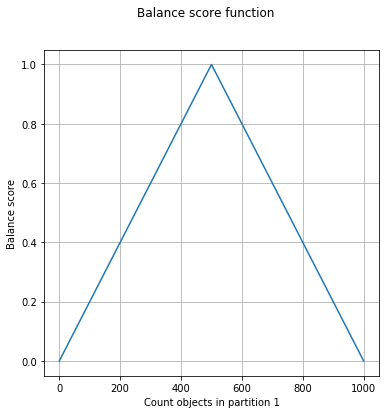

In [5]:
plot_array([balance_score(float(num), float(1000)) for num in range(0, 1001)], title='Balance score function',
           xlabel='Count objects in partition 1', ylabel='Balance score', figsize=(6, 6))


#### Select random pivot couples as pivot candidates

In [6]:
rand_indices = np.random.choice(vecs.shape[0], size=N_PIVOT_CANDIDATE_COUPLES * 2, replace=False)


In [7]:
pivot_cand = np.array(list(zip(*np.split(vecs[rand_indices], 2))))  # get pivot candidate couples


In [8]:
pivot_cand.shape


(1000, 2, 4096)

#### Assign partitions to objects and compute distances

In [9]:
sketch_matrix = np.zeros(shape=(vecs.shape[0], N_PIVOT_CANDIDATE_COUPLES))
partition_one_cnts = np.zeros(N_PIVOT_CANDIDATE_COUPLES)
sum_distances_from_hp = np.zeros(N_PIVOT_CANDIDATE_COUPLES)


In [10]:
logger = IterationLogger(log_by=LOG_BY)
for i, vec in enumerate(vecs):
    logger.next_iter()
    for j, (pivot_a, pivot_b) in enumerate(pivot_cand):
        partition, dist = assign_ghp_partition(vec, pivot_a, pivot_b, distance_to_hp=True)
        sketch_matrix[i][j] = partition
        sum_distances_from_hp[j] += dist
        if partition == 1:
            partition_one_cnts[j] += 1


INFO:IterationLogger| Started iteration no.: 1000
 Time from previous iteration: 65.83272361755371s
 Time from start: 65.83272385597229s
INFO:IterationLogger| Started iteration no.: 2000
 Time from previous iteration: 65.03700637817383s
 Time from start: 130.86973094940186s
INFO:IterationLogger| Started iteration no.: 3000
 Time from previous iteration: 66.69402384757996s
 Time from start: 197.56375551223755s
INFO:IterationLogger| Started iteration no.: 4000
 Time from previous iteration: 67.3701765537262s
 Time from start: 264.93393301963806s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 67.18426847457886s
 Time from start: 332.11820220947266s
INFO:IterationLogger| Started iteration no.: 6000
 Time from previous iteration: 67.37208676338196s
 Time from start: 399.4902894496918s
INFO:IterationLogger| Started iteration no.: 7000
 Time from previous iteration: 66.58867955207825s
 Time from start: 466.07896971702576s
INFO:IterationLogger| Started iterati

#### Distances from dividing hyperplane

In [11]:
mean_distances = sum_distances_from_hp / vecs.shape[0]


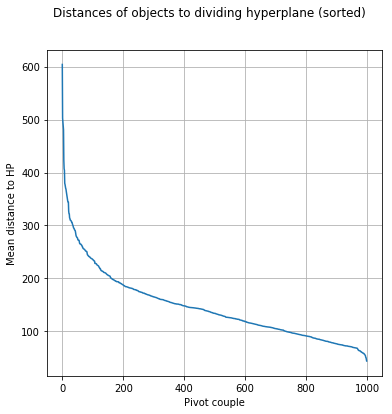

In [34]:
plot_array(sorted(mean_distances, reverse=True), title='Mean distances of objects to dividing hyperplane (sorted)',
           xlabel='Pivot couple', ylabel='Mean distance to HP', figsize=(6, 6))


#### Compute Balance scores
Larger balance score is better.

In [13]:
balance_scores = np.array([balance_score(cnt_part, vecs.shape[0]) for cnt_part in partition_one_cnts])


In [14]:
pd.DataFrame(balance_scores).describe()


,0
count,1000.000000
mean,0.469581
std,0.307395
min,0.000500
25%,0.179625
50%,0.467500
75%,0.739625
max,0.998750


In [15]:
sorted_args = np.argsort(balance_scores)[::-1]
balance_scores_sorted = balance_scores[sorted_args]
pivot_cand_sorted = pivot_cand[sorted_args]
sketch_matrix_sorted = sketch_matrix[:, sorted_args]


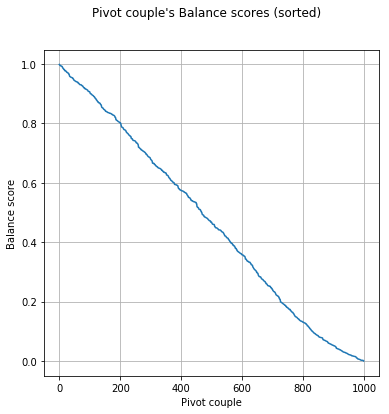

In [16]:
plot_array(balance_scores_sorted, title='Pivot couple\'s Balance scores (sorted)', xlabel='Pivot couple',
           ylabel='Balance score', figsize=(6, 6))


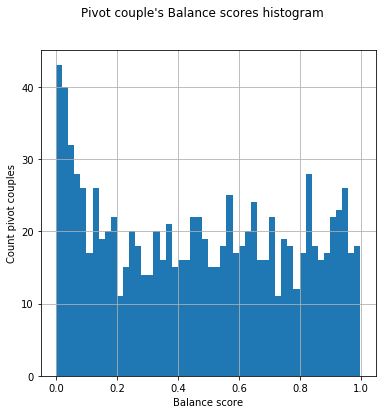

In [33]:
hist_array(balance_scores_sorted, bins=50, title='Pivot couple\'s Balance scores histogram', xlabel='Balance score',
           ylabel='Count pivot couples', figsize=(6, 6))


#### Correlation between balance score and distance from dividing hyperplane

In [17]:
mean_hp_distances_sorted = mean_distances[sorted_args]


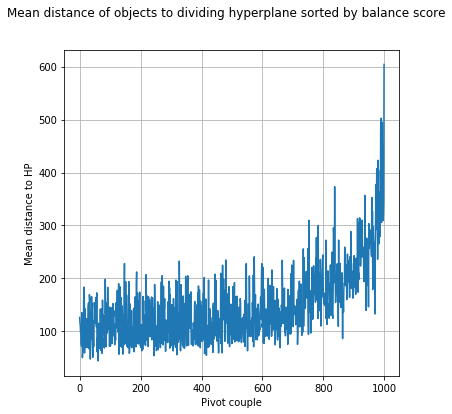

In [18]:
plot_array(mean_hp_distances_sorted, title='Mean distance of objects to dividing hyperplane sorted by balance score',
           xlabel='Pivot couple', ylabel='Mean distance to HP', figsize=(6, 6))


In [19]:
corr, pval = spearmanr(balance_scores_sorted, b=mean_hp_distances_sorted)


In [20]:
corr

-0.59093360898815095

In [21]:
pval

3.4626108769943026e-95

In [22]:
interpret_corr_result(corr, pval)


Computed correlation -0.590933608988 which can be interpreted as moderate negative linear dependence is statistically significant on confidence interval [0.95,1].


#### Persist pivots, their balance scores and distances from HP sorted by balance score

In [23]:
save_np_array(PIVOT_CAND_SAVE_FILE, pivot_cand_sorted)
save_np_array(BALANCE_SCORES_SAVE_FILE, balance_scores_sorted)
save_np_array(HP_DISTANCES_SAVE_FILE, mean_hp_distances_sorted)
save_np_array(SKETCH_MATRIX_SAVE_FILE, sketch_matrix_sorted)
